# Проект: Прогнозирование температуры плавления стали

## Постановка задачи заказчиком

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Ограничения

Заказчик хочет увидеть качество выполнения проекта при одних и тех же условиях.

RANDOM_STATE = 310723

## Формализация задачи

<b>Цель:</b> 

Построение модели предсказания температуры стали (задача регресии) на этапе обработки на основе имеющихся данных.

<b>Этапы:</b>
1. Разведочный анализ данных (EDA) и составление плана работы.
2. Уточнение задачи с заказчиком.
3. Разработка и тестирование модели.
4. Формирование итогового отчета.

<b>План работы:</b>
1. Разведочный анализ данных (EDA).
    - Изучение предоставленных заказчиком данных на предмет полноты, достаточности и непротиворечивости. 
    - Предобработка данных: устранение пропусков, дубликатов, аномалий, форматирование названий и типов данных.
    - Восстановление хронологии технологического процесса.
2. Уточнение и формализация задачи с заказчиком.
    - Выявление конечного потребителя разрабатываемой модели.
    - Определение требований, ограничений и формата выходных данных модели.
    - Формирование образа конечного результата.
    - Согласование плана и сроков работы.
3. Обучение модели.
    - Определение набора данных для формирования признаков, проверка на мультиколлинеарность.
    - Написание функций для выделения признаков из исходных данных, создание синтетических признаков.
    - Обучение разных моделей. Подбор гиперпараметров.
    - Тестирование лучшей модели.
    - Проверка модели на адекватность. Сравнение результата с константной моделью.
4. Написание отчета.
    - Описание достигнутых результатов.

## Разведочный анализ данных (EDA)

### Подготовка

Перед составлением плана работы проведем разведочный анализ (EDA) предоставленных заказчиком исходных данных на предмет полноты, достаточности и непротиворечивости для решения задачи.

Подключим необходимые библиотеки:

In [91]:
import pandas as pd
import numpy as np
import scipy
from datetime import datetime

Импортируем данные:

In [92]:
arc         = pd.read_csv('/datasets/data_arc_new.csv')
bulk        = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time   = pd.read_csv('/datasets/data_bulk_time_new.csv')
gas         = pd.read_csv('/datasets/data_gas_new.csv')
temp        = pd.read_csv('/datasets/data_temp_new.csv')
wire        = pd.read_csv('/datasets/data_wire_new.csv')
wire_time   = pd.read_csv('/datasets/data_wire_time_new.csv')

### Изучение исходных данных

Последовательно изучим все таблицы.

#### data_arc_new

In [93]:
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Таблица `data_arc_new` содержит временные интервалы нагрева стали в ковше и скорость расхода энергии на разных этапах обработки очередной партии `key`. Этапов нагрева для каждой партии может быть несколько.

Приведем к единому стилю названия столбцов:

In [94]:
arc.columns = ['key', 'heating_start', 'heating_end', 'power_active', 'power_reactive']

Проверим данные на полноту:

In [95]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heating_start   14876 non-null  object 
 2   heating_end     14876 non-null  object 
 3   power_active    14876 non-null  float64
 4   power_reactive  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Данные полные, пропуски отсутствуют. Тип данных в столбцах со временем приведем к типу `datetime`:

In [96]:
arc['heating_start'] = pd.to_datetime(arc['heating_start'])
arc['heating_end']   = pd.to_datetime(arc['heating_end'])

Проверим данные на аномалии:

In [97]:
arc.describe()

,key,power_active,power_reactive
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [98]:
arc.sort_values('power_reactive').head()

,key,heating_start,heating_end,power_active,power_reactive
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


In [99]:
arc[arc['key'] == 2116]

,key,heating_start,heating_end,power_active,power_reactive
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Найдена аномалия с реактивной мощностью. Отрицательная мощность могла бы говорить о накоплении энергии вместо ее расхода, однако абсолютная величина слишком велика и не типична как для партии, так и для всего датасета. Прослеживается сохранение пропорций между активной и реактивной мощностью, поэтому, чтобы не исключать всю партию из обучающей выборки, заменим аномалию типичным значением на основе линейной корреляции мощностей проблемной партии:

In [100]:
params = arc.loc[[9778, 9779, 9781]]
reg = scipy.stats.linregress(params['power_active'], params['power_reactive'])
# y = slope * x + intercept
arc.loc[[9780],'power_reactive'] = reg.slope * arc.loc[9780, 'power_active'] + reg.intercept
arc[arc['key'] == 2116]

,key,heating_start,heating_end,power_active,power_reactive
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.585332
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Посмотрим на длительность периодов нагрева:

In [101]:
arc['heating_time'] = arc['heating_end'] - arc['heating_start']
arc['heating_time'].describe()

count                        14876
mean     0 days 00:02:51.670946490
std      0 days 00:01:38.186802680
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
Name: heating_time, dtype: object

Длительность нагрева выглядит нормально.

Посмотрим на коэфициент реактивной мощности:

In [102]:
(arc['power_reactive'] / arc['power_active']).describe()

count    14876.000000
mean         0.734930
std          0.072419
min          0.538375
25%          0.679710
50%          0.724759
75%          0.781194
max          0.998261
dtype: float64

Реактивная мощность лежит в разумных пределах.

Узнаем количество партий:

In [103]:
len(arc['key'].unique())

3214

Нагрев производился в 3214 партиях.

Посчитаем количество итераций нагрева в партиях:

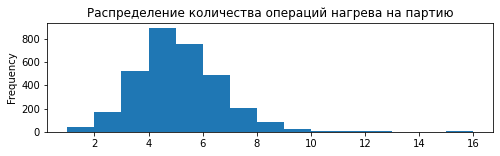

In [104]:
arc.groupby('key')['heating_start'].count().plot(kind='hist', bins=15, figsize=(8, 2),
                                                 title='Распределение количества операций нагрева на партию',
                                                 xlabel='Операций нагрева', ylabel='Кол-во партий');

Посмотрим на распределение мощности на графике:

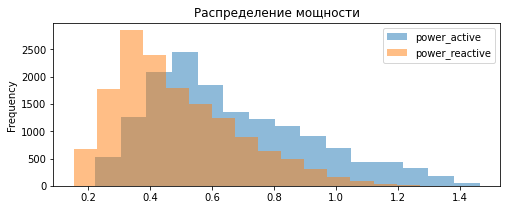

In [105]:
arc['power_active'].plot(kind='hist', alpha=0.5, bins=15, figsize=(8, 3), legend=True)
arc['power_reactive'].plot(kind='hist', alpha=0.5, bins=15, legend=True,
                         title='Распределение мощности', 
                         xlabel='Мощность',
                         ylabel='Количество записей');

Все диаграммы распределения выглядят нормально, данные в таблице предобработаны.

#### data_bulk_new

In [106]:
bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Таблица `data_bulk_new` содержит информацию об объемах добавляемых сыпучих материалах. Отсутствующие значения говорят о том, что в данной партии конкретный материал не добавлялся.

Приведем названия столбцов к единому стилю:

In [107]:
bulk_cols = ['key']
for col in bulk.columns.drop('key'):
    bulk_cols.append(col.lower().replace(' ', '_'))
bulk.columns = bulk_cols

In [108]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [109]:
len(bulk['key'].unique())

3129

3129 записей и столько же ключей - для каждой партии только одна строка с уникальным ключом содержит информацию о добавках без повторов и пропусков.

In [110]:
bulk.describe().round(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.00,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,1624.38,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,933.34,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,1.00,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,816.00,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,1622.00,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,2431.00,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,3241.00,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


Серьезных аномалий в объемах сыпучих добавок не прослеживается.

#### data_bulk_time_new

In [111]:
bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Таблица `data_bulk_time_new` содержит информацию о времени добавления сыпучих материалов, объемы которых описаны в `data_bulk_new`. Отсутствующие значения говорят о том, что в данной партии конкретный материал не добавлялся. Изучим таблицу аналогично `data_bulk_new`:

In [112]:
bulk_time.columns = bulk_cols

In [113]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Изменим тип столбцов со временем на `datetime`:

In [114]:
for col in bulk_time.columns.drop('key'):
    bulk_time[col] = pd.to_datetime(bulk_time[col])

In [115]:
len(bulk_time['key'].unique())

3129

Убедимся, что пропуски в обеих таблицах совпадают:

In [116]:
(bulk.isna() != bulk_time.isna()).sum().sum()

0

Обе таблицы однозначно связаны друг с другом.

#### data_gas_new

In [117]:
gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Таблица `data_gas_new` содержит информацию о продувке сплава инертным газом.

In [118]:
gas.columns = ['key', 'gas']

In [119]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [120]:
len(gas['key'].unique())

3239

Одна запись - одна партия.

In [121]:
gas.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [122]:
gas['gas'].sort_values(ascending=False).head(10)

319     77.995040
277     60.935689
2107    52.142373
2567    51.380229
116     50.581035
2105    45.638999
1461    43.655411
660     41.854643
525     39.728826
610     39.425706
Name: gas, dtype: float64

Отдельные значения сильно выше других, но говорить об аномалиях пока рано.

Проверим на графике:

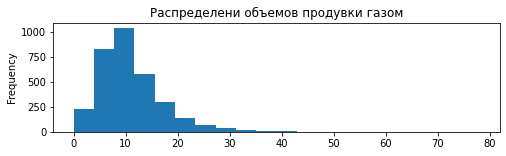

In [123]:
gas['gas'].plot(kind='hist', bins=20, figsize=(8, 2),
                title='Распределени объемов продувки газом',
                xlabel='Объем', ylabel='Кол-во партий');

Значения в таблице выглядят нормально, за исключением нескольких высоких значений.

#### data_temp_new

In [124]:
temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Таблица `data_temp_new` содержит информацию о температуре сплавов в определенные моменты времени. Измерений температуры в каждой партии может быть несколько.

In [125]:
temp.columns = ['key', 'time', 'temp']

In [126]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     18092 non-null  int64  
 1   time    18092 non-null  object 
 2   temp    14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Присутствует множество пропусков в значениях температур. По условию задачи, конечная температура является целевым признаком, и при ее отсутствии вся партия не может участвовать в обучении модели.

In [127]:
temp['time'] = pd.to_datetime(temp['time'])

Посмотрим на распределение пропусков в данных:

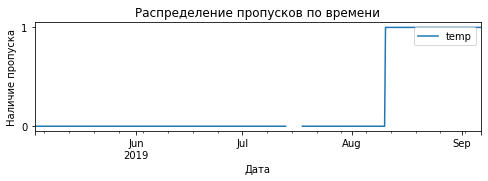

In [128]:
temp[['time', 'temp']].set_index('time').isna().resample('6h').max().plot(
    include_bool=True, figsize=(8, 2), title='Распределение пропусков по времени',
    xlabel='Дата', ylabel='Наличие пропуска', yticks=[0, 1]);

In [129]:
temp.loc[temp[temp['temp'].isna()].head(1).index[0]:].head(20)

,key,time,temp
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN


Начиная с определенной даты `2019-08-10 14:13:11` информация о партиях содержит только первое измерение температуры. Так как нам в качестве целевого признака нужно последнее измерение температуры, данные партии не могут использоваться для обучения и тестирования модели. От многих данных начиная с 2500 партии придется избавиться.

In [130]:
temp.describe().round(2)

,key,temp
count,18092.00,14665.00
mean,1616.46,1590.72
std,934.64,20.39
min,1.00,1191.00
25%,807.75,1580.00
50%,1618.00,1590.00
75%,2429.00,1599.00
max,3241.00,1705.00


In [131]:
temp['temp'].sort_values().head(10)

4883     1191.0
14283    1204.0
6784     1208.0
9050     1218.0
11495    1227.0
11499    1515.0
9359     1519.0
5117     1520.0
2881     1520.0
4889     1521.0
Name: temp, dtype: float64

In [132]:
temp[temp['key'] == temp.loc[4883]['key']]

,key,time,temp
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


In [133]:
temp[temp['key'] == temp.loc[14283]['key']]

,key,time,temp
14283,2561,2019-08-12 18:49:29,1204.0
14284,2561,2019-08-12 18:59:23,NaN
14285,2561,2019-08-12 19:06:26,NaN
14286,2561,2019-08-12 19:11:13,NaN
14287,2561,2019-08-12 19:17:08,NaN
14288,2561,2019-08-12 19:21:45,NaN


In [134]:
temp[temp['key'] == temp.loc[6784]['key']]

,key,time,temp
6784,1214,2019-06-18 08:01:03,1208.0
6785,1214,2019-06-18 08:17:56,1608.0
6786,1214,2019-06-18 08:31:10,1608.0
6787,1214,2019-06-18 08:43:56,1591.0


Несколько температур аномально низкие и находятся в начале обработки партии. Начальные значения температур будут включены в признаки, поэтому от таких партий лучше избавиться.

In [135]:
temp = temp.drop(temp[temp['key'].isin(temp[temp['temp'] < 1500]['key'])].index)

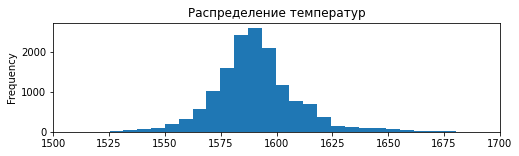

In [136]:
temp['temp'].plot(kind='hist', bins=30, figsize=(8, 2), xlim=(1500, 1700),
                  title='Распределение температур',
                  xlabel='Температура', ylabel='Кол-во записей');

Других аномалий в таблице не наблюдается.

#### data_wire_new

In [137]:
wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
wire_cols = ['key']
for col in wire.columns.drop('key'):
    wire_cols.append(col.lower().replace(' ', '_'))
wire.columns = wire_cols

Таблица `data_wire_new` содержит данные о добавлении проволоки аналогично таблице `data_bulk_new`.

In [139]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [140]:
len(wire['key'].unique())

3081

In [141]:
wire.describe().round(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.00,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,1623.43,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,933.00,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.00,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,823.00,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,1619.00,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,2434.00,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


Серьезных аномалий в объемах проволочных добавок не прослеживается.

#### data_wire_time_new

In [142]:
wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
wire_time.columns = wire_cols

Таблица `data_wire_time_new` аналогична `data_bulk_time_new`.

In [144]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [145]:
for col in wire_time.columns.drop('key'):
    wire_time[col] = pd.to_datetime(wire_time[col])

In [146]:
len(wire_time['key'].unique())

3081

In [147]:
(wire.isna() != wire_time.isna()).sum().sum()

0

Аномалий не замечено.

### Восстановление технологического процесса

Исходные данные распределены по разным таблицам, что затрудняет изучение взаимосвязей процессов, происходящих с каждой партией. Объеденим все события в одну одну, восстановив хронологию технологического процесса для каждой партии.

Таблицы объема и времени добавления легирующих элементов развернуты в виде сводных таблиц, их необходимо свернуть. Затем добавим все события в единую хронологическую таблицу:

In [148]:
# Добавим события начала и конца нагрева. Активную и реактивную мощность просуммируем
arc['power_total'] = arc['power_active'] + arc['power_reactive']

arc_start = arc[['key', 'heating_start', 'power_total']].rename(columns={'heating_start': 'time', 'power_total': 'value'})
arc_start['variable'] = 'heating_start'

arc_end = arc[['key', 'heating_end', 'power_total']].rename(columns={'heating_end': 'time', 'power_total': 'value'})
arc_end['variable'] = 'heating_end'

# Добавим события измерения температуры
temp_full = temp.rename(columns={'temp': 'value'})
temp_full['variable'] = 'temp'

# Свернем сыпучие добавки
bulk_full = pd.melt(bulk_time, id_vars=['key']).rename(columns={'value': 'time'}).join(
    pd.melt(bulk, id_vars=['key'])['value'])

# Свернем проволочные добавки
wire_full = pd.melt(wire_time, id_vars=['key']).rename(columns={'value': 'time'}).join(
    pd.melt(wire, id_vars=['key'])['value'])

# Объединим все события в одну хронологическую таблицу
events = pd.concat([arc_start, arc_end, bulk_full, wire_full, temp_full]) \
    .dropna().sort_values('time').reset_index(drop=True)
events.head(40)

,key,time,value,variable
0,1,2019-05-03 11:02:04,1571.000000,temp
1,1,2019-05-03 11:02:14,0.516383,heating_start
2,1,2019-05-03 11:06:02,0.516383,heating_end
3,1,2019-05-03 11:06:19,60.059998,wire_1
4,1,2019-05-03 11:07:18,1604.000000,temp
5,1,2019-05-03 11:07:28,1.243096,heating_start
6,1,2019-05-03 11:10:33,1.243096,heating_end
7,1,2019-05-03 11:10:43,154.000000,bulk_15
8,1,2019-05-03 11:11:34,1618.000000,temp
9,1,2019-05-03 11:11:44,1.010773,heating_start


Теперь мы можем восстановить хронологию обработки типичной партии сплава:
1. Замер начальной температуры сплава.
2. Нагрев сплава.
3. Добавление легирующих элементов. Иногда не добавляется ничего.
4. Контрольный замер температуры. Повторение цикла с пункта 2 до готовности сплава.

### Выводы по EDA

Разведочный анализ данных показал, что данные о технологическом процессе распределены по нескольким таблицам. В таблицах присутствуют редкие аномалии. Есть значительное количество пропусков в данных об измерении температуры - обучить модель на партиях с пропусками температуры не получится, эти данные исключены.

Данные могут быть использованы для формирования признаков для обучения модели. В данных присутсвует целевой признак - последнее измерение температуры в партии. Можно переходить к обучению предсказательной модели.

## Подготовка признаков к обучению

### Определение признаков

Для обучения модели необходимо выделить набор важных взаимно независимых признаков, чтобы не перегрузать модель параметрами и не переобучить. При этом допускается исключение некоторых малозначимых признаков.

Исходя из известного нам технологического процесса и имеющихся данных, можно выделить следующие факторы, влияющие на конечную температуру сплава:
- предыдущая температура
- длительность и интенсивность итераций нагрева
- состав сплава
- объемы продувки газом
- время обработки

Данные факторы можно использовать как признаки для обучения модели. Извлечь их можно из исходных данных.

Как показал EDA, технологический процесс каждой партии состоит из нефиксированного количества одинаковых итераций: нагрев -> добавки -> измерение температуры. Таким образом можно декомпозировать обработку партий на отдельные итерации, на основе которых и обучить модель.

Какие признаки для каждой итерации возможно сформировать:
- Изменение температуры. Любая из итераций имеет начальную и конечную температуры. Компонент целевого признака.
- Мощность нагрева. Объем содержимого ковша-печи предполагается постоянным, поэтому температура тесно связана со скоростью нагрева.
- Накопленный объем сыпучих материалов (15 признаков) и проволоки (9 признаков). Предполагается, что изначальный сплав всех партий одинаковый, и меняется только при добавлении легирующих элементов на разных этапах обработки партии.
- Объем продувки инертными газами. Данный признак остается неизменным для любой итерации в партии.
- Длительность итерации. Нельзя исключать фактор потери энергии на теплообмен с окружающей средой и другие скрытые временные факторы.

### Формирование признаков

Напишем функции для преобразования исходных данных в признаки для обучения модели. Эти же функции будут использоваться для преобразования сырых тестовых данных для формирования предсказаний.

Функция загрузки данных. Потребуется для тестирования:

In [149]:
def load_data(path):
    arc         = pd.read_csv(path + 'data_arc_new.csv', parse_dates=[1, 2])
    bulk        = pd.read_csv(path + 'data_bulk_new.csv')
    bulk_time   = pd.read_csv(path + 'data_bulk_time_new.csv', parse_dates=[*range(1, 16)])
    gas         = pd.read_csv(path + 'data_gas_new.csv')
    temp        = pd.read_csv(path + 'data_temp_new.csv', parse_dates=[1])
    wire        = pd.read_csv(path + 'data_wire_new.csv')
    wire_time   = pd.read_csv(path + 'data_wire_time_new.csv', parse_dates=[*range(1, 10)])
    return arc, bulk, bulk_time, gas, temp, wire, wire_time

*НОВАЯ ФУНКЦИЯ после ревью v2*

In [151]:
def create_features_new(raw_data):
    arc, bulk, bulk_time, gas, temp, wire, wire_time = raw_data
    
    # Переименуем столбцы
    arc.columns = ['key', 'heating_start', 'heating_end', 'power_active', 'power_reactive']
    bulk_cols = ['key']
    for col in bulk.columns.drop('key'):
        bulk_cols.append(col.lower().replace(' ', '_'))
    bulk.columns = bulk_cols
    bulk_time.columns = bulk_cols
    gas.columns = ['key', 'gas']
    temp.columns = ['key', 'time', 'temp']
    wire_cols = ['key']
    for col in wire.columns.drop('key'):
        wire_cols.append(col.lower().replace(' ', '_'))
    wire.columns = wire_cols
    wire_time.columns = wire_cols
    
    # Объедним обработку партий в одну таблицу. За основу возьмем таблицу с температурами.
    # Исключим партии, в которых известны не все температуры
    temp_clean = temp.drop(temp[temp['key'].isin(temp[temp.isna()['temp']]['key'])].index)
    
    # Выделим начальную и конечную температуры
    batches = temp_clean.groupby('key', as_index=False).agg('first')
    batches[['time_end', 'temp_end']] = temp.groupby('key', as_index=False).agg('last')[['time', 'temp']]
    
    # Определим общую длительность обработки партии в секундах
    batches['time_passed'] = (batches['time_end'] - batches['time']).dt.seconds
    
    # Присоединим нагрев и найдем его суммарную энергию как 
    # произведение суммы мощностей на время нагрева
    batches = batches.join(arc.set_index('key'), on='key', how='inner')
    batches['power_total'] = batches['power_active'] + batches['power_reactive']
    batches['heating_time'] = batches['heating_end'] - batches['heating_start']
    batches['energy_total'] = batches['power_total'] * batches['heating_time'].dt.seconds
    batches['energy_total'] = batches[['key', 'energy_total']].groupby('key', as_index=False).agg('cumsum')
    batches = batches.groupby('key', as_index=False).agg('last')
    
    # Присоединим продувку газом
    batches = batches.join(gas.set_index('key'), on='key', how='inner')
    
    # Присоединим сыпучие и проволочные добавки
    batches = batches.join(pd.melt(bulk_time, id_vars=['key']).rename(columns={'value': 'time'}) \
                           .join(pd.melt(bulk, id_vars=['key'])['value'], how='inner') \
                           .pivot(index='key', columns='variable', values='value').fillna(0), 
                           on='key', how='inner')
    batches = batches.join(pd.melt(wire_time, id_vars=['key']).rename(columns={'value': 'time'}) \
                           .join(pd.melt(wire, id_vars=['key'])['value'], how='inner') \
                           .pivot(index='key', columns='variable', values='value').fillna(0), 
                           on='key', how='inner')
    
    # Исключим лишние столбцы
    batches = batches.drop(['time', 'time_end', 'power_active', 'power_reactive', 'power_total', \
                            'heating_end', 'heating_start', 'heating_time'], axis=1).set_index('key')

    # Таблица обработки партий готова. Отделим целевой признак
    features = batches.drop('temp_end', axis=1)
    target = batches['temp_end']
    
    return features, target

Функции готовы. Исследуем мультиколлинеарность. Посмотрим на корреляцию полученных признаков по всем данным:

In [154]:
import matplotlib.pyplot as plt

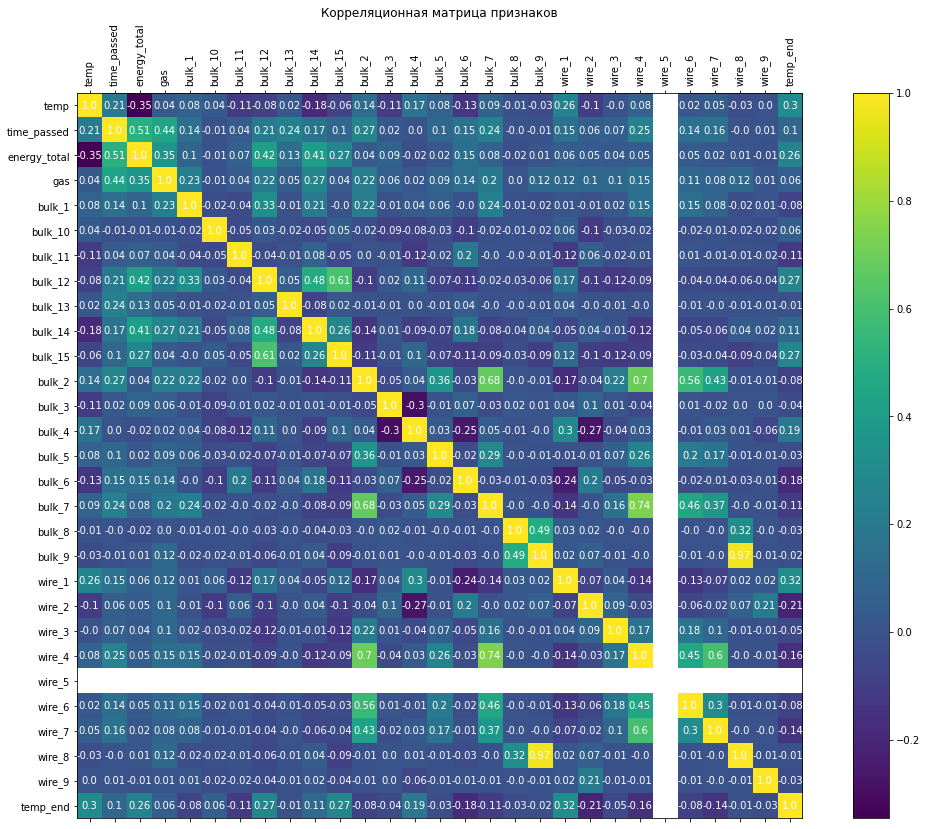

In [155]:
# Сбросим лишние столбцы с разведочного этапа
try:
    arc = arc.drop(['heating_time', 'power_total'], axis=1)
except:
    pass

# ПРИМЕНЕНИЕ ФУНКЦИИ после ревью v2
# Воспользуемся новой функцией для извлечения признаков
features, target = create_features_new([arc, bulk, bulk_time, gas, temp, wire, wire_time])

corr = features.copy()
corr['temp_end'] = target.copy()

f = plt.figure(figsize=(18, 13))
plt.matshow(corr.corr(), fignum=f.number)
plt.xticks(range(corr.shape[1]), corr, rotation=90)
plt.yticks(range(corr.shape[1]), corr)
cb = plt.colorbar()
plt.title('Корреляционная матрица признаков')

# ДОБАВЛЕНО ПОСЛЕ РЕВЬЮ v1
# Добавим числовую аннотацию значений на графике
corr = corr.corr()
for i in range(corr.shape[1]):
    for j in range(corr.shape[1]):
        plt.annotate(corr.iloc[i, j].round(2), 
        xy=(i, j), ha='center', va='center',color='white');

Исследуем данные на наличие мультиколлинерности. Используем коэфициент инфляции дисперции (VIF):

In [156]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [157]:
vif_data = pd.DataFrame(index=features.columns)
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [158]:
vif_data.sort_values('VIF', ascending=False)

,VIF
bulk_9,67.896013
wire_8,57.292058
temp,14.764628
energy_total,9.404714
wire_1,9.107832
bulk_14,7.677575
bulk_12,7.236606
time_passed,6.886660
gas,6.162091
bulk_15,5.364978


Сразу 10 признаков имеют высокий VIF > 5, а для признака `wire_5` коэфициент вообще не может быть расчитан. Избавимся от него и от признака с наибольшим коэфициентом - `bulk_9`.

In [159]:
features_vif = features.drop(['wire_5', 'bulk_9'], axis=1)

In [160]:
vif_data = pd.DataFrame(index=features_vif.columns)
vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]
vif_data.sort_values('VIF', ascending=False).head(10)

,VIF
temp,14.762862
energy_total,9.404481
wire_1,9.100725
bulk_14,7.645186
bulk_12,7.236055
time_passed,6.861710
gas,6.118922
bulk_15,5.353841
wire_4,3.493628
bulk_2,2.923037


VIF значительно снизился, но еще далек от идеала.

Полное удаление признаков с высоким VIF - решение грубое, но, в отличие от метода анализа главных компонент (PCA) и метода частичных наименьших квадратов (PLS), сохраняет исходные переменные, позволяя однозначнее интерпретировать влияение исходных данных на предсказания.

Удалим признак начальной температуры:

In [161]:
features_vif = features.drop(['wire_5', 'bulk_9', 'temp'], axis=1)

In [162]:
vif_data = pd.DataFrame(index=features_vif.columns)
vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
                   for i in range(len(features_vif.columns))]
vif_data.sort_values('VIF', ascending=False).head(10)

,VIF
energy_total,9.133779
bulk_12,7.047815
time_passed,6.853110
bulk_14,6.699284
wire_1,6.339513
gas,6.025606
bulk_15,5.125104
wire_4,3.486813
bulk_2,2.902138
bulk_7,2.709443


Инфляция признаков снизилась и не превышает VIF = 10. В дальнейшем при обучении модели будем исключать данные признаки.

### Обучение моделей

Обучим разные модели и найдем лучшую. Обучать будем на наборе по циклам.

In [178]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Подготовим признаки, их масштабирование и кросс-валидацию:

In [179]:
# Для подбора моделей возьмем только обучающую выборку
features, target = create_features_new([arc, bulk, bulk_time, gas, temp, wire, wire_time])

X_train, _, y_train, _ = train_test_split(
    features, target, test_size=0.25, random_state=310723)

scaler = StandardScaler()
cv = KFold(n_splits=5, shuffle=True, random_state=310723)

Устраним коррелирующие столбцы:

In [180]:
X_train = X_train.drop(['wire_5', 'bulk_9', 'temp'], axis=1)

#### LinearRegression

In [181]:
lr = LinearRegression()

pipe = Pipeline([('transformer', scaler), ('estimator', lr)])
scores = cross_val_score(pipe, X_train, y_train, cv = cv, scoring='neg_mean_absolute_error')
-scores.mean()

7.662419434292813

MAE линейной регрессии на этапе кросс-валидации: 7.66

#### RandomForestRegressor

Для случайного леса переберем несколько наборов гиперпараметров и найдем лучший:

In [182]:
%%time
rfr = RandomForestRegressor(random_state=310723)

param_grid = { 
    'estimator__n_estimators': [200, 400, 600],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__max_depth' : [20, 30, 40] }

pipe = Pipeline([('transformer', scaler), ('estimator', rfr)])
searcher = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs = -1)
searcher.fit(X_train, y_train)

CPU times: user 4min 33s, sys: 1.42 s, total: 4min 34s
Wall time: 4min 35s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer', StandardScaler()),
                                       ('estimator',
                                        RandomForestRegressor(random_state=310723))]),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [20, 30, 40],
                         'estimator__max_features': [None, 'sqrt', 'log2'],
                         'estimator__n_estimators': [200, 400, 600]},
             scoring='neg_mean_absolute_error')

In [183]:
searcher.best_params_

{'estimator__max_depth': 20,
 'estimator__max_features': 'log2',
 'estimator__n_estimators': 200}

In [184]:
-searcher.best_score_

7.248067973414349

Лучшее значение MAE случайного леса на этапе кросс-валидации: 7.25

Лучшие гиперпараметры: max_depth: 20, max_features: log2, n_estimators: 200

### Тестирование лучшей модели

Лучшая модель: RandomForestRegressor. Протестируем её.

Для обучения воспользуемся предобработанными данными, а для тестирования - оригинальными из файла:

In [185]:
# Предобработанные данные (обучающие)
features, target = create_features_new([arc, bulk, bulk_time, gas, temp, wire, wire_time])

X_train, _, y_train, _ = train_test_split(
    features, target, test_size=0.25, random_state=310723)

# Данные из файла (тестовые, без предобработки)
X, y = create_features_new(load_data('/datasets/'))

_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.25, random_state=310723)

Устраним коррелирующие столбцы:

In [186]:
X_train = X_train.drop(['wire_5', 'bulk_9', 'temp'], axis=1)
X_test = X_test.drop(['wire_5', 'bulk_9', 'temp'], axis=1)

Обучим модель:

In [187]:
rfr = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=20, random_state=310723)
pipe = Pipeline([('transformer', scaler), ('estimator', rfr)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 RandomForestRegressor(max_depth=20, max_features='log2',
                                       n_estimators=200,
                                       random_state=310723))])

In [188]:
y_pred = pipe.predict(X_test)
mean_absolute_error(y_test, y_pred)

4.818195774970045

Лучшая модель показала результат MAE = 4.82. Порог точности = 6.8 преодолен.

### Проверка модели на адекватность

Проверим, что наша модель справляется лучше, чем константные модели.

#### Константная модель

Рассмотрим модель, всегда предсказывающую одинаковое значение - медиану обучающей выборки.

In [100]:
mean_absolute_error(y_test, [y_train.median()] * len(y_test))

7.499142367066895

MAE константной модели (медиана) = 7.5 и не преодолевает порог = 6.8.

Построенная нами модель прошла проверку на адекватность.


Изучим значимость признаков в полученной модели:

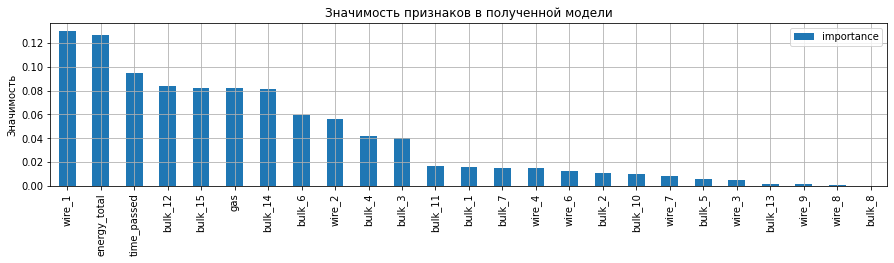

In [102]:
pd.DataFrame({'importance': rfr.feature_importances_},
             index=X_train.columns).sort_values('importance', ascending=False).plot(
    kind='bar', grid=True, figsize=(15, 3),
    title='Значимость признаков в полученной модели',
    ylabel='Значимость');

Наибольшее влияние на предсказания модели оказывают элемент `wire_1` и энергия нагрева. Также важно учитывать время, объемы продувки газом, и другие часто добавляемые легирующие элементы, такие как `bulk_12`, `bulk_15`, `bulk_14`. Наименее важный вклад в предсказания вносят редко добавляемые легирующие элементы.

## Отчет по проекту

### Разведочный анализ данных (EDA)

После первичной постановки задачи и предоставления данных был проведен разведочный анализ данных (EDA). В ходе анализа установлено, что данные заказчика о технологическом процессе нормализованы, разные этапы разделены на несколько разных таблиц. В каждой из таблиц отсутствовала информация о некоторых партиях, что не позволяло восстановить все этапы обработки всех партий. Все партии начиная с #2500 имели только начальную температуру и не имели конечной. Остальная имеющаяся информация сохраняла полноту и достаточность для восстановления партий и решения задачи. Всего принято в работу информация о 2325 партиях.

На этапе предобработки выявлены аномально низкие (на ~300° ниже) начальные температуры в 5-ти партиях, которые были исключены из работы из-за трудностей восстановления этой ключевой информации. Исправлено аномальное отрицательное значение реактивной мощности в одной из партий методом линейной регрессии на основе других значений в партии. Данные приведены к единому формату для дальнейшего выделения признаков.

Предобработанные данные были объединены в единую таблицу с восстановлением хронологии технологического процесса. Были выявлены схожие циклические этапы измерения температуры, нагрева и добавления легирующих элементов в каждой партии.

### Уточнение задачи с заказчиком

Задача уточнена с заказчиком после разведочного анализа данных. Конечным потребителем являются сотрудники компании, планирующие использовать информацию о прогнозируемой температуре для регуляции энергопотребления и сокращения производственных расходов.

К числу первоначальных технических требований к модели добавились:
- Необходимость использования исключительно начальной и конечной температуры партии.
- Требование использовать только полные партии, т.е. содержащих информацию об этапах измерения температур, нагрева, продувки газом, добавления сыпучих и проволочных материалов.
- Соотношение тренировочной и тестовой выборок - 3:1.
- На этапе подбора модели использовать кросс-валидауцию.
- На тестовой выборке проверять только одну (лучшую) модель.
- Проверить модель на адекватность на тесте с константной моделью.
- Продемонстрировать значимость признаков и их влияние на предсказания.
- Метрикой качества модели использовать MAE как наиболее просто интерпретируемую метрику потерь.

Критерием оценки проекта является соблюдение технических требований и значение метрики MAE модели на тестовых данных. Чем MAE ниже, тем лучше. MAE модели не должна превышать значение = 6.8.

### Обучение модели

Целевым признаком модели стала конечная температура партии. В качестве признаков-предикторов были выделены 28 признаков:
1. Начальная температура партии. 1 признак.
2. Энергия нагрева. Рассчитана как произведение суммы активной и пассивной мощностей на время нагрева. 1 признак.
3. Время обработки партии. Рассчитано как интервал между начальным и конечным измерением температуры. 1 признак.
4. Объемы продувки газом. 1 признак.
5. Объемы сыпучих добавок. 15 признаков.
6. Объемы проволочных добавок. 9 признаков.

Написаны функции для удобного быстрого извлечения признаков из исходных таблиц.

Исследование взаимных корреляций признаков показало наличие мультиколлинеарности между признаками. Коэфициент инфляции дисперсии (VIF) некоторых признаков превышал значение = 10. Во избежание ошибок обучения модели от мультиколлинеарности было необходимо избавиться, однако такие качественные методы как анализ основных компонентов (RCA) и частичная регрессия методом наименьших квадратов (PLS) нем не подошли, так как линейные преобразования признаков хоть и решали проблему их мультиколлинеарности, но делали их неинтерпретируемыми, что нарушает техническое требование нашей задачи. Поэтому было принято решение удалить признаки с наибольшим VIF > 10. Так были исключены признаки сыпучей добавки №9 и начальной температуры партии, а также признак проволочной добавки №5 ввиду малого количества партий с ней. Количество признаков-предикторов сократилось до 25.

Для обучения использованы модели линейной регрессии и случайного леса из библиотеки Scikit-learn. Перед обучением признаки нормализовались (масштабировались), обучение производилось с кросс-валидацией на тренировочных данных. Линейная модель показала значения метрики MAE = 7.66, случайный лес после перебора гиперпараметров - MAE = 7.25 при параметрах max_depth=20, max_features=log2, n_estimators=200.

На тестовой выборке случайный лес показал значение MAE = 4.82, что ниже максимального порога = 6.8. При этом константная модель по медиане конечной температуры на обучающей выборке показала MAE = 7.5. Построенная модель прошла проверку на адекватность.

Наибольшее влияние на предсказания построенной модели оказывают проволочная добавка №1 и энергия нагрева. Также важно учитывать время, объемы продувки газом, и другие часто добавляемые легирующие элементы, такие как сыпучие материалы №12, №14 и №15. Наименее важный вклад в предсказания вносят редко добавляемые легирующие элементы.

### Выводы

Построена модель предсказания температуры стали. 
<br>Средняя абсолютная ошибка (MAE) модели составляет 4.82 и не превышает порога в 6.8.
<br>Модель готова к внедрению в производство и эксплуатации.

<b>Цель проекта достигнута.</b>

### Что можно улучшить

Можно улучшить конвеер (pipeline) и превратить в коробочное решение для предсказания.